## Evaluating RAG with RAGAs using GPT-4o

Ragas is a **framework for evaluating Retrieval Augmented Generation (RAG) pipelines**.

Ragas provides you with the tools/metrics based on the latest research for evaluating LLM-generated text to give you insights about your RAG pipeline. Ragas can be integrated with your CI/CD to provide continuous checks to ensure performance.

GPT4-o is used as an LLM to generate responses out of semantically close context chunks.

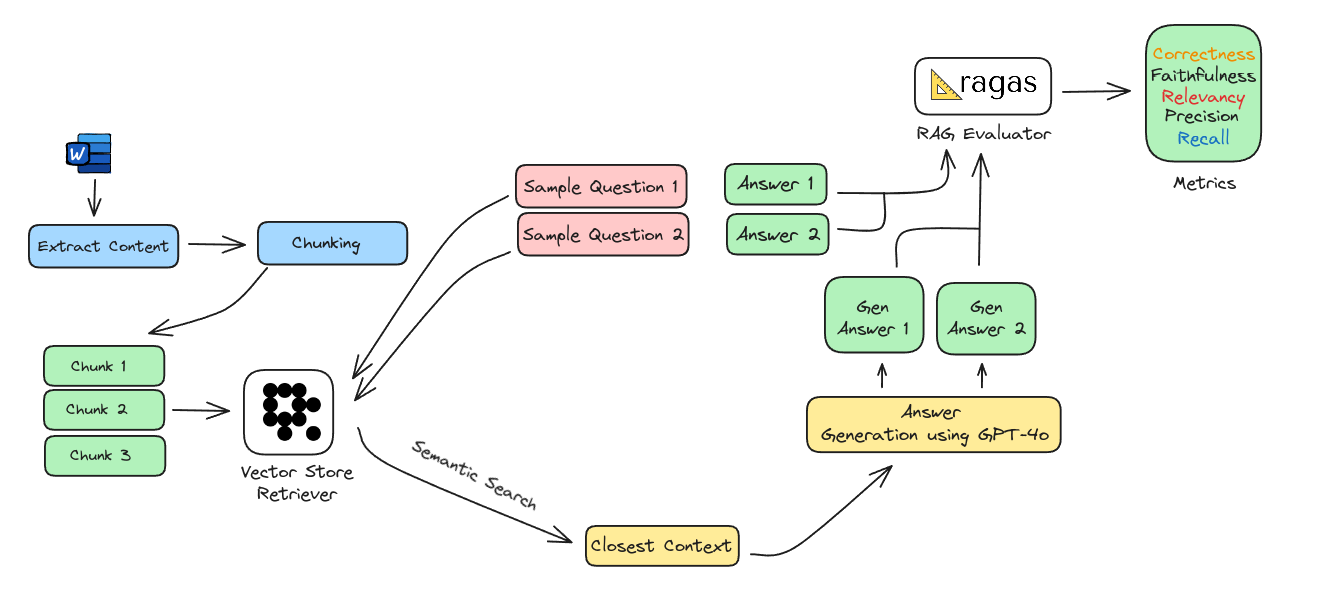

In [ ]:
!pip install langchain openai lancedb ragas -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.5/973.5 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.6/320.6 kB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.9/18.9 MB 71.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.5/308.5 kB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.8/122.8 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.8/22.8 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

### Setup `OPENAI_API_KEY` as an environment variable

In [ ]:
import os

os.environ["OPENAI_API_KEY"] = "sk-proj-..."

### Load .txt file and convert them into chunks

In [ ]:
import requests
from langchain.document_loaders import TextLoader
from langchain.text_splitter import CharacterTextSplitter

url = "https://raw.githubusercontent.com/hwchase17/chroma-langchain/master/state_of_the_union.txt"
res = requests.get(url)
with open("state_of_the_union.txt", "w") as f:
    f.write(res.text)

# Load the data
loader = TextLoader("./state_of_the_union.txt")
documents = loader.load()

# Chunk the data
text_splitter = CharacterTextSplitter(chunk_size=200, chunk_overlap=10)
chunks = text_splitter.split_documents(documents)

### Setup Retriever

Retriever utilizes **LanceDB** for scalable vector search and advanced retrieval in RAG, delivering blazing fast performance for searching large sets of embeddings.

In [ ]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import LanceDB
import lancedb

openai_embed = OpenAIEmbeddings()

# Setup lancedb
db = lancedb.connect("/tmp/lancedb")
table = db.create_table(
    "raga_eval",
    data=[{"vector": openai_embed.embed_query("Hello World"), "text": "Hello World"}],
    mode="overwrite",
)

# Populate vector database
vectorstore = LanceDB.from_documents(
    client=table, documents=chunks, embedding=openai_embed, by_text=False
)

# Define vectorstore as retriever to enable semantic search
retriever = vectorstore.as_retriever()

### Setup RAG Pipeline with Prompt template

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser

# Define LLM
llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

# Define Prompt template
template = """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question.
If you don't know the answer, just say that you don't know.
Use two sentences maximum and keep the answer concise.
Question: {question}
Context: {context}
Answer:
"""

prompt = ChatPromptTemplate.from_template(template)

# Setup RAG pipeline
rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

### Sample Questions with their Expected Answers

Define a set of questions with their answers for creating dataset including ground truth, generated answers with their context using which they are generated.

In [ ]:
from datasets import Dataset

questions = [
    "What did the president say about Justice Breyer?",
    "What did the president say about Intel's CEO?",
    "What did the president say about gun violence?",
]
ground_truth = [
    "The president said that Justice Breyer has dedicated his life to serve the country and thanked him for his service.",
    "The president said that Pat Gelsinger is ready to increase Intel's investment to $100 billion.",
    "The president asked Congress to pass proven measures to reduce gun violence.",
]
answers = []
contexts = []

# Inference
for query in questions:
    answers.append(rag_chain.invoke(query))
    contexts.append(
        [docs.page_content for docs in retriever.get_relevant_documents(query)]
    )

# To dict
data = {
    "question": questions,
    "answer": answers,
    "contexts": contexts,
    "ground_truth": ground_truth,
}

# Convert dict to dataset
dataset = Dataset.from_dict(data)

### RAGA Evaluation Pipeline

Simple pipeline of RAGA for evaluation with the listed metrics to understand and evaluate the RAG system.

**Metrics** on which we will evaulate are answer_correctness,
faithfulness,
answer_similarity,
context_precision,
context_utilization,
context_recall,
context_relevancy,
answer_relevancy, and
context_entity_recall

In [ ]:
from ragas import evaluate
from ragas.metrics import (
    answer_correctness,
    faithfulness,
    answer_similarity,
    context_precision,
    context_utilization,
    context_recall,
    context_relevancy,
    answer_relevancy,
    context_entity_recall,
)


# evaluating dataest on listed metrics
result = evaluate(
    dataset=dataset,
    metrics=[
        answer_correctness,
        faithfulness,
        answer_similarity,
        context_precision,
        context_utilization,
        context_recall,
        context_relevancy,
        answer_relevancy,
        context_entity_recall,
    ],
)


df = result.to_pandas()

Evaluating:   0%|          | 0/27 [00:00<?, ?it/s]

In [ ]:
# evaluation metrics
df

,question,answer,contexts,ground_truth,answer_correctness,faithfulness,answer_similarity,context_precision,context_utilization,context_recall,context_relevancy,answer_relevancy,context_entity_recall
0,What did the president say about Justice Breyer?,The president honored Justice Stephen Breyer a...,"[And I did that 4 days ago, when I nominated C...",The president said that Justice Breyer has ded...,0.415487,1.0,0.911948,1.0,1.0,1.0,0.200000,0.841589,0.500000
1,What did the president say about Intel's CEO?,"The president said that Intel’s CEO, Pat Gelsi...","[Intel’s CEO, Pat Gelsinger, who is here tonig...",The president said that Pat Gelsinger is ready...,0.619998,0.0,0.980103,1.0,1.0,1.0,0.090909,0.897084,0.750000
2,What did the president say about gun violence?,The president called on Congress to pass prove...,[And I ask Congress to pass proven measures to...,The president asked Congress to pass proven me...,0.606230,1.0,0.924895,1.0,1.0,1.0,0.250000,0.914888,0.666667
